This notebook how to minimally implement **sharpness-aware minimization** in TensorFlow with the CIFAR10 dataset. Sharpness-aware minimization (SAM) was proposed in the paper - [Sharpness-Aware Minimization for Efficiently Improving Generalization](https://openreview.net/pdf?id=6Tm1mposlrM)<sup>*</sup>. Some notable differences in this implementation:
* ResNet20 (attributed to [this repository](https://github.com/GoogleCloudPlatform/keras-idiomatic-programmer/blob/master/zoo/resnet/resnet_cifar10.py)) is used as opposed to PyramidNet and WideResNet.
* ShakeDrop regularization has not been used.
* Two simple augmentation transformations (random crop and random brightness) have been used as opposed to Cutout, AutoAugment.
* Adam has been used as the optimizer with the default arguments as provided by TensorFlow with a `ReduceLROnPlateau`. Table 1 of the original paper suggests to use SGD with different configurations.
* Instead of training for full number of epochs I used early stopping with a patience of 10.

I referred to the following resources for this study -
* [Original Paper](https://openreview.net/pdf?id=6Tm1mposlrM)
* [davda54](https://github.com/davda54)'s [PyTorch implementation](https://github.com/davda54/sam)

*<sub>arXiv version of the paper can be found [here](https://arxiv.org/abs/2010.01412).</sub>

## Initial Setup

In [86]:
!git clone https://github.com/sayakpaul/Sharpness-Aware-Minimization-TensorFlow

fatal: destination path 'Sharpness-Aware-Minimization-TensorFlow' already exists and is not an empty directory.


In [87]:
import sys
sys.path.append("Sharpness-Aware-Minimization-TensorFlow")

In [88]:
import tensorflow as tf
tf.random.set_seed(42)
print(tf.__version__)

2.12.0


In [89]:
try: # detect TPUs
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  8


In [90]:
import matplotlib.pyplot as plt
import resnet_cifar10
import utils
import time

## Load Dataset and Prepare Data Loaders

In [91]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(f"Training samples: {len(x_train)}")
print(f"Testing samples: {len(x_test)}")

Training samples: 50000
Testing samples: 10000


In [92]:
BATCH_SIZE = 128 * strategy.num_replicas_in_sync
print(f"Batch size: {BATCH_SIZE}")
AUTO = tf.data.AUTOTUNE

def scale(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.cast(label, tf.int32)
    return image, label

def augment(image,label):
    image = tf.image.resize_with_crop_or_pad(image, 40, 40) # Add 8 pixels of padding
    image = tf.image.random_crop(image, size=[32, 32, 3]) # Random crop back to 32x32
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    image = tf.clip_by_value(image, 0., 1.)

    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (
    train_ds
    .shuffle(1024)
    .map(scale, num_parallel_calls=AUTO)
    .map(augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (
    test_ds
    .map(scale, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

Batch size: 1024


## Encapsulate SAM Logic

SAM is implemented as follows -

<center>
<img src="https://i.ibb.co/qRSfNX7/image.png"></img><br>
<small>Source: Original Paper</small>
</center>

In [93]:
import tensorflow as tf
tf.config.run_functions_eagerly(False)

class SAMModel(tf.keras.Model):
    def __init__(self, resnet_model, rho=0.05):
        """
        p, q = 2 for optimal results as suggested in the paper
        (Section 2)
        """
        super(SAMModel, self).__init__()
        self.resnet_model = resnet_model
        self.rho = rho

    def train_step(self, data):
        (images, labels) = data
        e_ws = []
        with tf.GradientTape() as tape:
            predictions = self.resnet_model(images)
            loss = self.compiled_loss(labels, predictions)
        trainable_params = self.resnet_model.trainable_variables
        gradients = tape.gradient(loss, trainable_params)
        grad_norm = self._grad_norm(gradients)
        scale = self.rho / (grad_norm + 1e-12)

        for (grad, param) in zip(gradients, trainable_params):
            e_w = grad * scale
            param.assign_add(e_w)
            e_ws.append(e_w)

        with tf.GradientTape() as tape:
            predictions = self.resnet_model(images)
            loss = self.compiled_loss(labels, predictions)

        sam_gradients = tape.gradient(loss, trainable_params)
        for (param, e_w) in zip(trainable_params, e_ws):
            param.assign_sub(e_w)

        self.optimizer.apply_gradients(
            zip(sam_gradients, trainable_params))

        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        (images, labels) = data
        predictions = self.resnet_model(images, training=False)
        loss = self.compiled_loss(labels, predictions)
        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def _grad_norm(self, gradients):
        norm = tf.norm(
            tf.stack([
                tf.norm(grad) for grad in gradients if grad is not None
            ])
        )
        return norm

## Define Callbacks

In [94]:
train_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5,
        patience=3, verbose=1
    )
]

## Initialize Model with SAM and Train It

In [95]:
with strategy.scope():
    model = SAMModel(utils.get_training_model())
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
print(f"Total learnable parameters: {model.resnet_model.count_params()/1e6} M")

Total learnable parameters: 0.575114 M


In [96]:

start = time.time()
history = model.fit(train_ds,
                   validation_data=test_ds,
                   callbacks=train_callbacks,
                   epochs=100)
print(f"Total training time: {(time.time() - start)/60.} minutes")

Epoch 1/100
49/49 [==============================] - 53s 478ms/step - loss: 2.7215 - accuracy: 0.1255 - val_loss: 2.0776 - val_accuracy: 0.1972 - lr: 0.0010
Epoch 2/100
49/49 [==============================] - 5s 113ms/step - loss: 2.1034 - accuracy: 0.1775 - val_loss: 1.9579 - val_accuracy: 0.2792 - lr: 0.0010
Epoch 3/100
49/49 [==============================] - 5s 104ms/step - loss: 2.0251 - accuracy: 0.2129 - val_loss: 1.8435 - val_accuracy: 0.3401 - lr: 0.0010
Epoch 4/100
49/49 [==============================] - 5s 99ms/step - loss: 1.9375 - accuracy: 0.2525 - val_loss: 1.7419 - val_accuracy: 0.3582 - lr: 0.0010
Epoch 5/100
49/49 [==============================] - 5s 109ms/step - loss: 1.8240 - accuracy: 0.2929 - val_loss: 1.6099 - val_accuracy: 0.4068 - lr: 0.0010
Epoch 6/100
49/49 [==============================] - 5s 98ms/step - loss: 1.7716 - accuracy: 0.3167 - val_loss: 1.5944 - val_accuracy: 0.4092 - lr: 0.0010
Epoch 7/100
49/49 [==============================] - 5s 106ms/ste

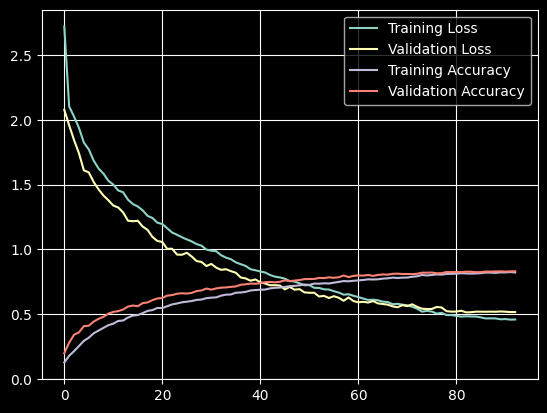

In [97]:
 # Set the style to dark mode
plt.style.use('dark_background')

utils.plot_history(history)

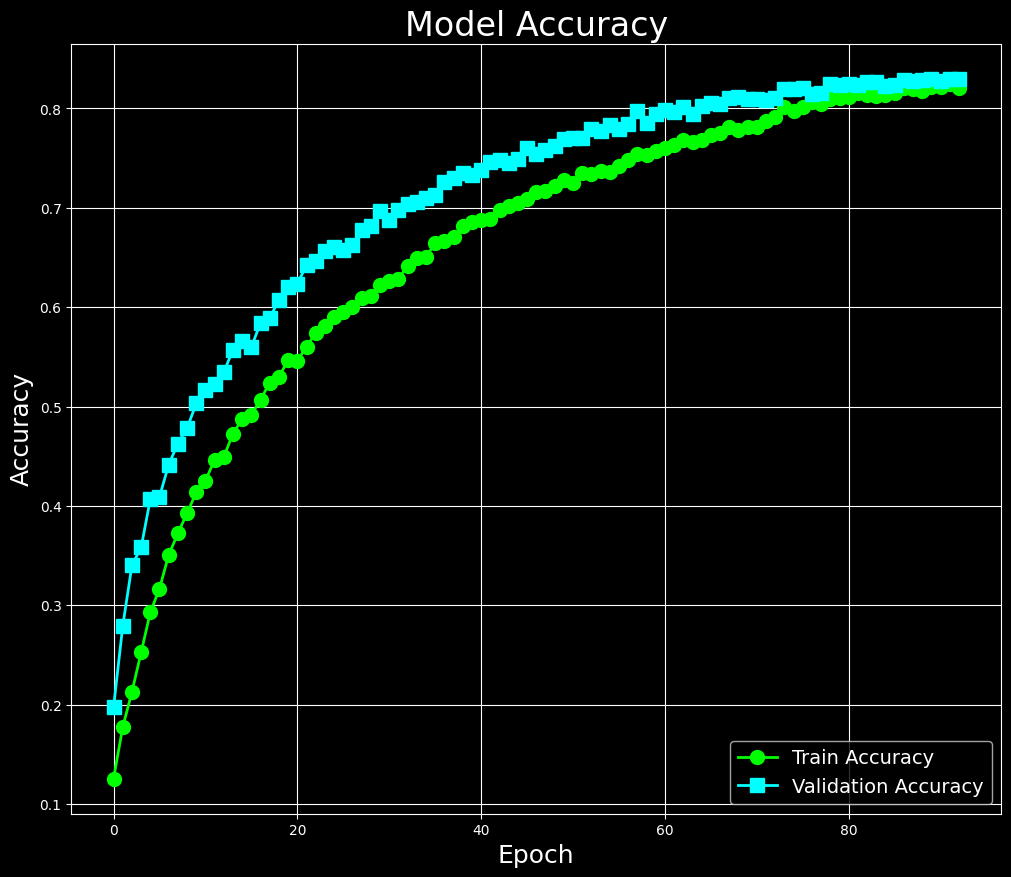

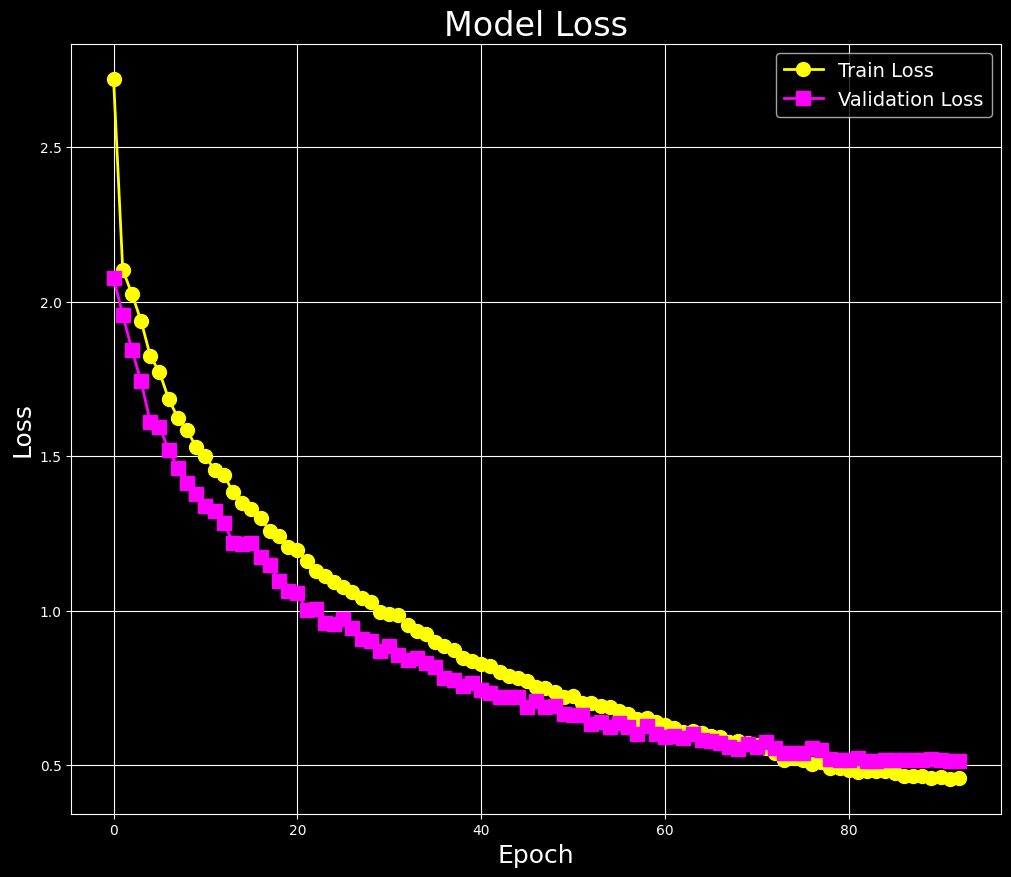

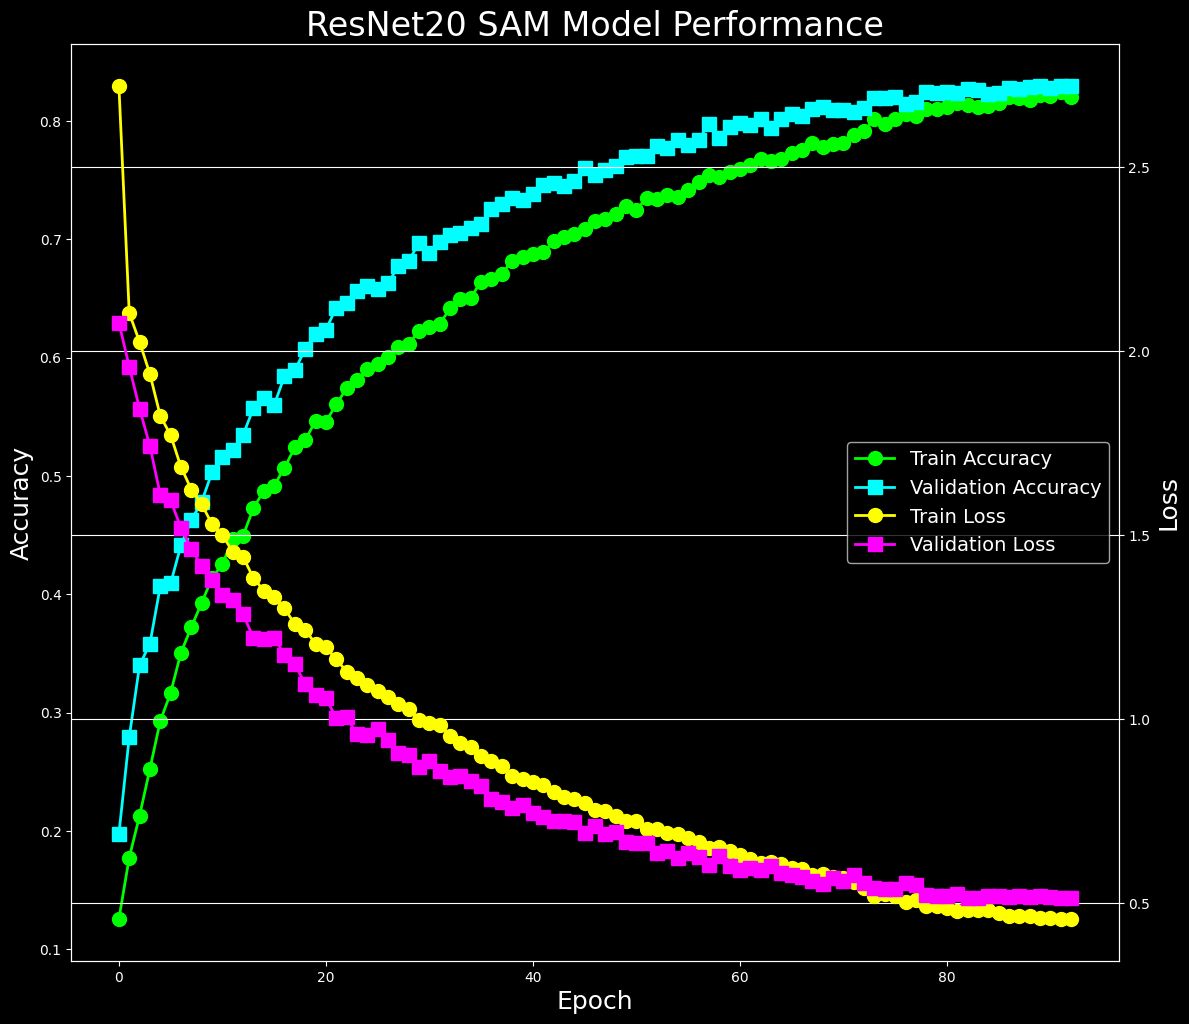

In [98]:
import matplotlib.pyplot as plt




# summarize history for accuracy
plt.figure(figsize=(12, 10))
plt.plot(history.history['accuracy'], 'o-', color='lime', linewidth=2, markersize=10, label='Train Accuracy')
plt.plot(history.history['val_accuracy'], 's-', color='cyan', linewidth=2, markersize=10, label='Validation Accuracy')
plt.title('Model Accuracy', fontsize=24)
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(loc='lower right', fontsize=14)
plt.grid(True)
plt.show()

# summarize history for loss
plt.figure(figsize=(12, 10))
plt.plot(history.history['loss'], 'o-', color='yellow', linewidth=2, markersize=10, label='Train Loss')
plt.plot(history.history['val_loss'], 's-', color='magenta', linewidth=2, markersize=10, label='Validation Loss')
plt.title('Model Loss', fontsize=24)
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(loc='upper right', fontsize=14)
plt.grid(True)
plt.show()

# summarize all history in one graph
fig, ax1 = plt.subplots(figsize=(12, 10))
color_acc = 'lime'
color_val_acc = 'cyan'
ax1.set_xlabel('Epoch', fontsize=18)
ax1.set_ylabel('Accuracy', fontsize=18)
ax1.plot(history.history['accuracy'], 'o-', color=color_acc, linewidth=2, markersize=10, label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], 's-', color=color_val_acc, linewidth=2, markersize=10, label='Validation Accuracy')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color_loss = 'yellow'
color_val_loss = 'magenta'
ax2.set_ylabel('Loss', fontsize=18)
ax2.plot(history.history['loss'], 'o-', color=color_loss, linewidth=2, markersize=10, label='Train Loss')
ax2.plot(history.history['val_loss'], 's-', color=color_val_loss, linewidth=2, markersize=10, label='Validation Loss')
ax2.tick_params(axis='y')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='center right', fontsize=14)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('ResNet20 SAM Model Performance', fontsize=24)
plt.grid(True)
plt.show()

In [99]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_ds)

# Print the accuracy
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Loss: {loss*100:.2f}%")

# Calculate the error rate
error_rate = 1 - accuracy

# Print the error rate
print(f"Error rate of the model: {error_rate*100:.2f}%")

10/10 [==============================] - 3s 27ms/step - loss: 0.5127 - accuracy: 0.8267
Accuracy: 82.67%
Loss: 51.27%
Error rate of the model: 17.33%


## Train a Regular ResNet20 Model

In [100]:
with strategy.scope():
    model2 = utils.get_training_model()

model2.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

start = time.time()
history2 = model2.fit(train_ds,
                   validation_data=test_ds,
                   callbacks=train_callbacks,
                   epochs=200) # 200 eppochs since SAM takes two backprop steps for an update
print(f"Total training time: {(time.time() - start)/60.} minutes")

Epoch 1/200
49/49 [==============================] - 43s 402ms/step - loss: 1.9107 - accuracy: 0.2903 - val_loss: 2.8871 - val_accuracy: 0.1481 - lr: 0.0010
Epoch 2/200
49/49 [==============================] - 4s 77ms/step - loss: 1.6185 - accuracy: 0.4071 - val_loss: 4.6591 - val_accuracy: 0.1458 - lr: 0.0010
Epoch 3/200
49/49 [==============================] - 4s 91ms/step - loss: 1.4752 - accuracy: 0.4649 - val_loss: 4.2903 - val_accuracy: 0.1450 - lr: 0.0010
Epoch 4/200
48/49 [============================>.] - ETA: 0s - loss: 1.3564 - accuracy: 0.5082
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
49/49 [==============================] - 4s 82ms/step - loss: 1.3553 - accuracy: 0.5088 - val_loss: 3.1137 - val_accuracy: 0.1831 - lr: 0.0010
Epoch 5/200
49/49 [==============================] - 4s 92ms/step - loss: 1.2501 - accuracy: 0.5521 - val_loss: 2.1639 - val_accuracy: 0.3029 - lr: 5.0000e-04
Epoch 6/200
49/49 [==============================] - 5s 92ms

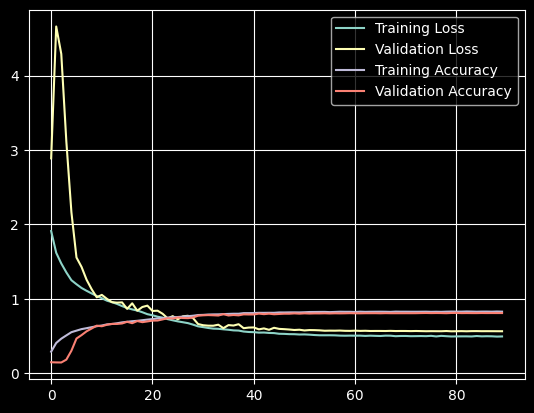

In [101]:
utils.plot_history(history2)

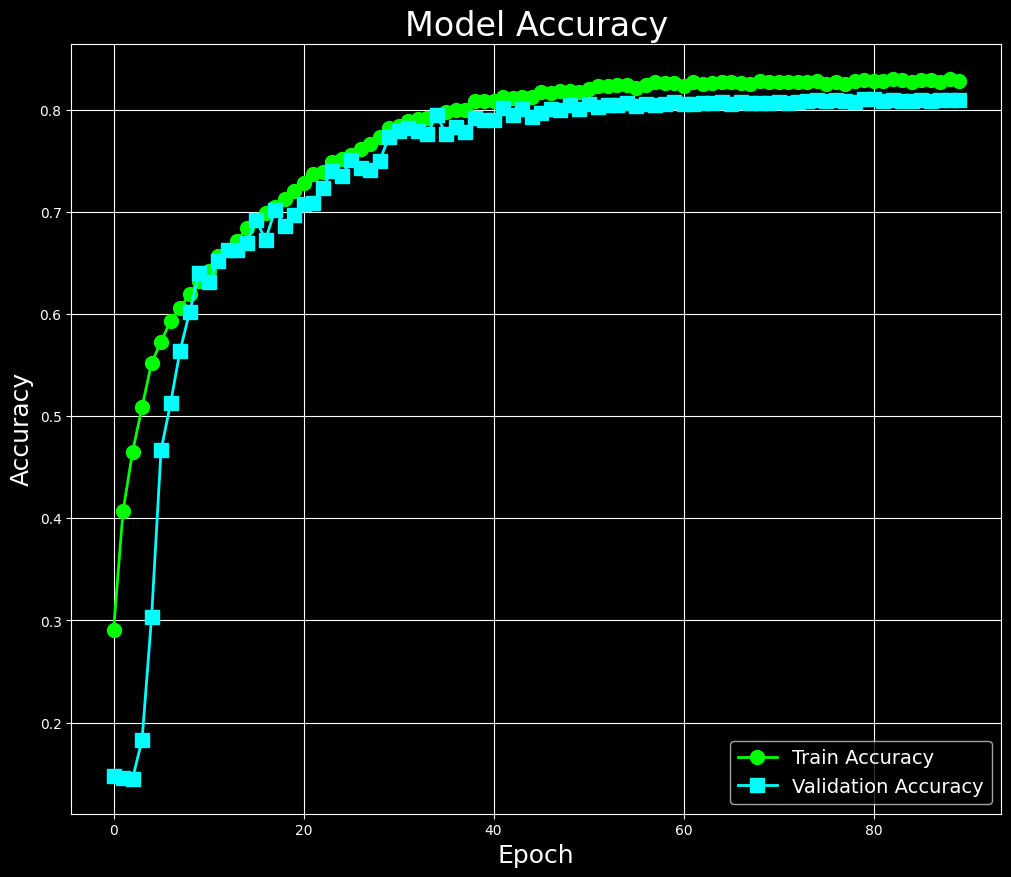

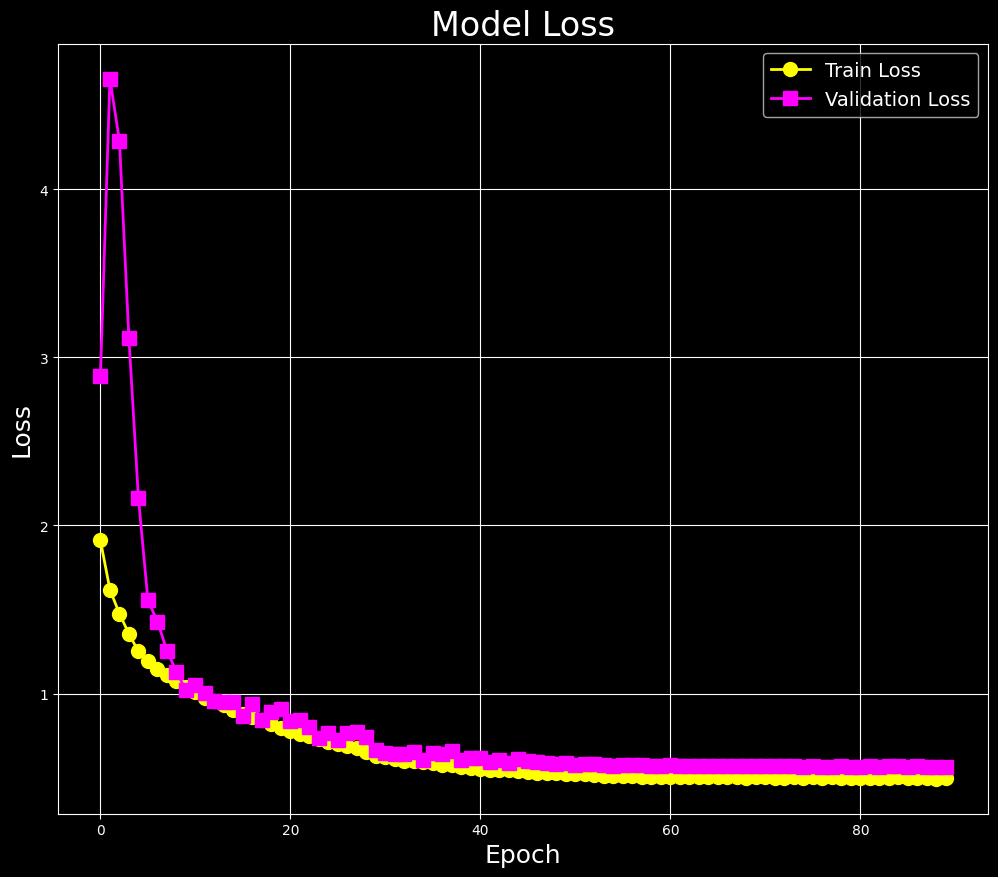

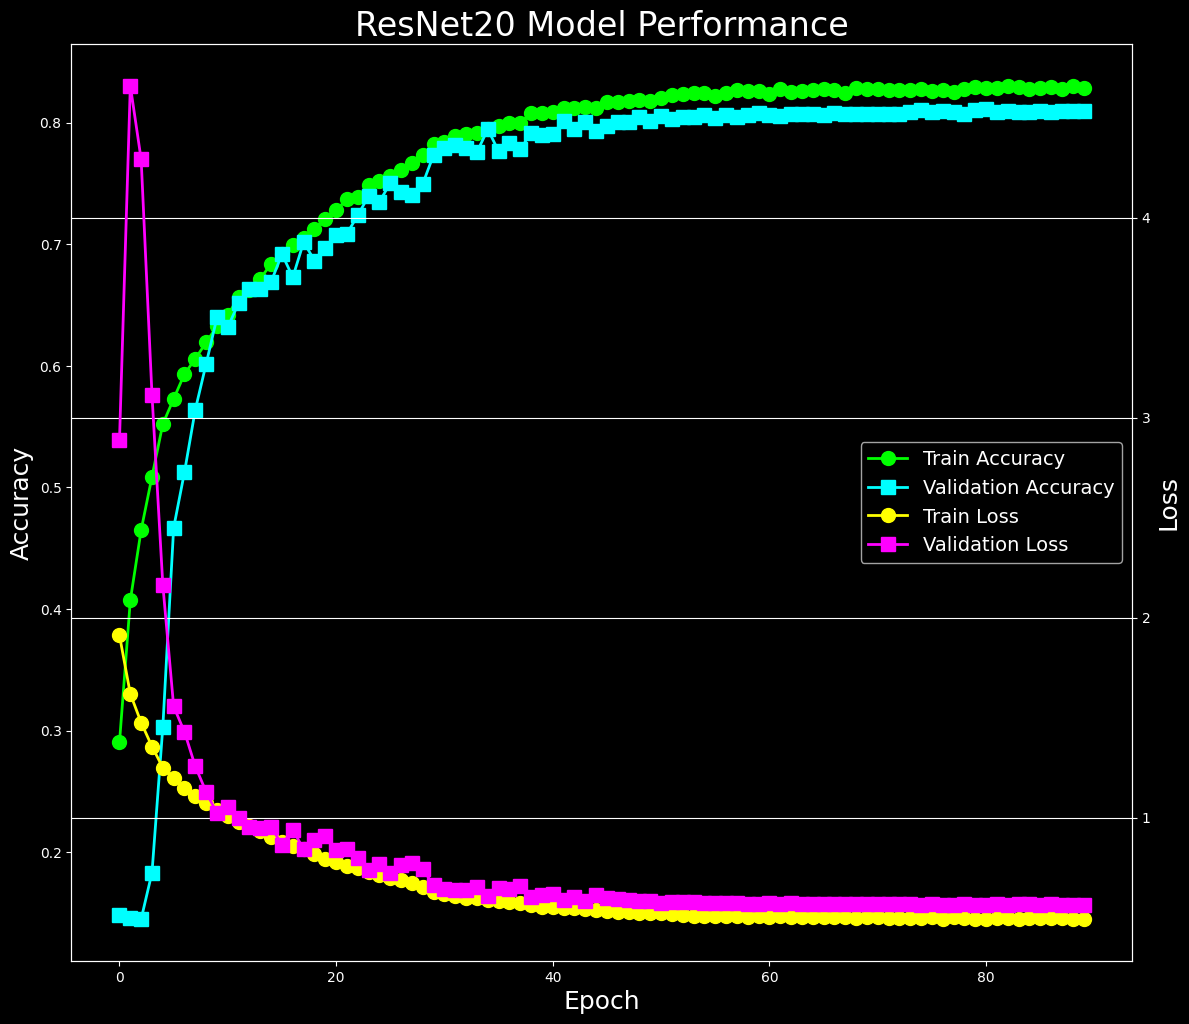

In [102]:
import matplotlib.pyplot as plt


    # Set the style to dark mode
plt.style.use('dark_background')

# summarize history for accuracy
plt.figure(figsize=(12, 10))
plt.plot(history2.history['accuracy'], 'o-', color='lime', linewidth=2, markersize=10, label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], 's-', color='cyan', linewidth=2, markersize=10, label='Validation Accuracy')
plt.title('Model Accuracy', fontsize=24)
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(loc='lower right', fontsize=14)
plt.grid(True)
plt.show()

# summarize history for loss
plt.figure(figsize=(12, 10))
plt.plot(history2.history['loss'], 'o-', color='yellow', linewidth=2, markersize=10, label='Train Loss')
plt.plot(history2.history['val_loss'], 's-', color='magenta', linewidth=2, markersize=10, label='Validation Loss')
plt.title('Model Loss', fontsize=24)
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(loc='upper right', fontsize=14)
plt.grid(True)
plt.show()

# summarize all history in one graph
fig, ax1 = plt.subplots(figsize=(12, 10))
color_acc = 'lime'
color_val_acc = 'cyan'
ax1.set_xlabel('Epoch', fontsize=18)
ax1.set_ylabel('Accuracy', fontsize=18)
ax1.plot(history2.history['accuracy'], 'o-', color=color_acc, linewidth=2, markersize=10, label='Train Accuracy')
ax1.plot(history2.history['val_accuracy'], 's-', color=color_val_acc, linewidth=2, markersize=10, label='Validation Accuracy')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color_loss = 'yellow'
color_val_loss = 'magenta'
ax2.set_ylabel('Loss', fontsize=18)
ax2.plot(history2.history['loss'], 'o-', color=color_loss, linewidth=2, markersize=10, label='Train Loss')
ax2.plot(history2.history['val_loss'], 's-', color=color_val_loss, linewidth=2, markersize=10, label='Validation Loss')
ax2.tick_params(axis='y')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='center right', fontsize=14)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('ResNet20 Model Performance', fontsize=24)
plt.grid(True)
plt.show()

In [103]:
# Evaluate the model on the test dataset
loss, accuracy = model2.evaluate(test_ds)

# Print the accuracy
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Loss: {loss*100:.2f}%")

# Calculate the error rate
error_rate = 1 - accuracy

# Print the error rate
print(f"Error rate of the model: {error_rate*100:.2f}%")

10/10 [==============================] - 2s 31ms/step - loss: 0.5637 - accuracy: 0.8109
Accuracy: 81.09%
Loss: 56.37%
Error rate of the model: 18.91%
